## The Problem
Unlike the Equity Market, the Bond Market suffers from a severe lack of information.  With no quotes publicly available, the best way to get a quote is to solicit multiple brokers and wait for a reply.  Benchmark Solutions plans to predict accurate prices that incorporate interest rate data, trades or quotes of the bond in question, trades or quotes of other bonds or CDS of the issuer of the bond in question as well as other input sources. 

#### Background
While the initial competition was 6 years ago, several individuals have continued to develop models to address this problem. 

>The winning kaggle team ‘upbeat’ was able to predict prices with .6803 MAE in 2012.
    
>In 2017, Swetava Ganguli and Jared Dunnmon published a paper using a variety of machine learning models.  Their best score was .6668 WEPS.

Reading the specifics of the Ganguli, Dunnmon paper and reviewing their results I decided to use multilayer Neural Networks and GLMs to create better and faster predictions.

This table is the results of the Ganguli, Dunnmon paper.  In their review of the results the authors concluded that “NNs and GLMs give best results in terms of combined speed and accuracy.” And “the success of neural networks on this dataset implies that investigating the application of multilayer networks and deep learning methods to this problem may yield better bond price predictions.”

<img src="./results.png">

In [4]:
import pandas as pd

In [5]:
import numpy as np
np.random.seed(seed = 42)

In [34]:
df = pd.read_csv('./Data/train.csv')
submit = pd.read_csv('./Data/test.csv')

## Importing Data & Cleaning

Instantiating our data from the Benchmark Solution Kaggle Data (https://www.kaggle.com/c/benchmark-bond-trade-price-challenge/data).  While the data set is generally clean, there were a couple steps to go further with cleaning.  Notably, dummying out the categorical varaiables and filling the time-series NaN lags with -1000 so they can be utilized in the model. 

This is some information about the data and columns:
US corporate bond trade data is provided. Each row includes trade details, some basic information about the traded bond, and information about the previous 10 trades. Contestants are asked to predict trade price.

Column details:
1. id: The row id. bond_id: The unique id of a bond to aid in timeseries reconstruction. (This column is only present in the train data)
2. trade_price: The price at which the trade occured. (This is the column to predict in the test data)
3. weight: The weight of the row for evaluation purposes. This is calculated as the square root of the time since the last trade and then scaled so the mean is 1.
4. current_coupon: The coupon of the bond at the time of the trade.
5. time_to_maturity: The number of years until the bond matures at the time of the trade.
6. is_callable: A binary value indicating whether or not the bond is callable by the issuer.
7. reporting_delay: The number of seconds after the trade occured that it was reported.
8. trade_size: The notional amount of the trade.
9. trade_type: 2=customer sell, 3=customer buy, 4=trade between dealers. We would expect customers to get worse prices on average than dealers.
10. curve_based_price: A fair price estimate based on implied hazard and funding curves of the issuer of the bond.

11. received_time_diff_last{1-10}: The time difference between the trade and that of the previous {1-10}.
21. trade_price_last{1-10}: The trade price of the last {1-10} trades.
31. trade_size_last{1-10}: The notional amount of the last {1-10} trades.
41. trade_type_last{1-10}: The trade type of the last {1-10} trades.
51. curve_based_price_last{1-10}: The curve based price of the last {1-10} trades.

In [35]:
dummies = pd.get_dummies(df['trade_type'])
df = pd.concat([df,dummies], axis = 1)
df = df.drop('trade_type', axis = 1)

In [11]:
df.drop('id',axis = 1,inplace = True)

df.fillna(-1000,inplace = True)
submit.fillna(-1000,inplace = True)

In [ ]:
## Preprocessing and feature selection


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv2D

C:\Users\tbaca\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


#### PCA for Feature Selection
After the data was prepared, I used principal component analysis (PCA) on the entire data set in order to see if there existed a reduced feature set that retains the majority of the explanatory power of the full feature set.  Other typical preprocessing steps were taken, including train-test-split and standard scaling.

In [8]:
X = df.drop('trade_price', axis = 1)
y = df['trade_price']



In [9]:
X_submit = submit

In [10]:
pca = PCA()
ss = StandardScaler()

In [11]:
pca_X = pca.fit_transform(X)
#pca_submit = pca.transform(X_submit)

In [12]:
final_X = ss.fit_transform(pca_X)
#final_submit = ss.transform(pca_submit)

In [13]:
import seaborn as sns

In [14]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_X,y,test_size = .5)

C:\Users\tbaca\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Models

My initial model was based on the suggestions of Ganguli and Dunnmon using a 5 layer Neural network and editing the number of nodes per layer.
Second and third models were GLMs which included an ordinary least squares regression (OLS) and a weighted least squares regression (WLS)
My fourth model was a Long Short-Term Memory Neural Network of similar design to my original model - 5 layers with varying node sizes.
I included a random forest regressor as a fifth additional option.


#### Neural Networks

This first model is my RNN, with 5 layers of varying size.

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

input_units = X_train.shape[1]
hidden_units = input_units

model.add(Dense(hidden_units, input_dim=input_units, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
#model.add(Dropout())

model.add(Dense(1))

from keras.optimizers import Adam

#model.compile(loss='mean_squared_error', optimizer='adam')

adam = Adam(lr=0.001)
model.compile(loss='mean_absolute_error', optimizer=adam)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=None)

#Add Dropout Layers (ask Matt)
#Ask about Batch Size
#RNN potentially before PCA and Scaling - based on correlations from above



Train on 381339 samples, validate on 381339 samples
Epoch 1/100
381339/381339 [==============================] - 22s 58us/step - loss: 2.5525 - val_loss: 0.7491
Epoch 2/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.8019 - val_loss: 0.8324
Epoch 3/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.7422 - val_loss: 0.7000
Epoch 4/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.7128 - val_loss: 0.7331
Epoch 5/100
381339/381339 [==============================] - 23s 59us/step - loss: 0.6936 - val_loss: 0.7203
Epoch 6/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.6690 - val_loss: 0.5951
Epoch 7/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.6549 - val_loss: 0.6390
Epoch 8/100
381339/381339 [==============================] - 23s 60us/step - loss: 0.6365 - val_loss: 0.5736
Epoch 9/100
381339/381339 [==============================] - 23s 59us/step -

381339/381339 [==============================] - 25s 64us/step - loss: 0.4518 - val_loss: 0.4412
Epoch 76/100
381339/381339 [==============================] - 23s 59us/step - loss: 0.4522 - val_loss: 0.4317
Epoch 77/100
381339/381339 [==============================] - 22s 58us/step - loss: 0.4518 - val_loss: 0.4616
Epoch 78/100
381339/381339 [==============================] - 22s 58us/step - loss: 0.4511 - val_loss: 0.4623
Epoch 79/100
381339/381339 [==============================] - 23s 59us/step - loss: 0.4520 - val_loss: 0.4559
Epoch 80/100
381339/381339 [==============================] - 21s 54us/step - loss: 0.4516 - val_loss: 0.4552
Epoch 81/100
381339/381339 [==============================] - 21s 54us/step - loss: 0.4519 - val_loss: 0.4528
Epoch 82/100
381339/381339 [==============================] - 21s 55us/step - loss: 0.4510 - val_loss: 0.4468
Epoch 83/100
381339/381339 [==============================] - 22s 58us/step - loss: 0.4507 - val_loss: 0.4337
Epoch 84/100
381339/381

Text(0.5,0,'Epoch')

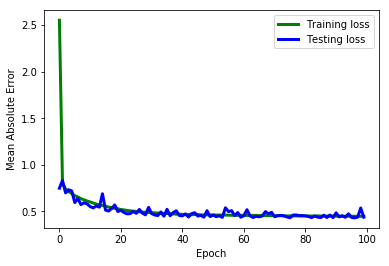

In [35]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss', c = 'g', lw = 3)
plt.plot(test_loss, label='Testing loss',c = 'b', lw = 3)
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')

In [42]:
RNNpredsTest = model.predict(X_test)
RNNpredsTrain = model.predict(X_train)

RNNTestScore = mean_absolute_error(y_test, RNNpredsTest)
RNNTrainScore = mean_absolute_error(y_train, RNNpredsTrain)



NameError: name 'model' is not defined

#### LSTM
This is the next NN.  The idea with the Long Short-Term Memory model is that the time-series data would provide better predictability and better results.  Important to note, the factor function is used to determine batch size, LSTMs require batches to be divisible by the sample shape.


In [16]:
train_X_reshape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
test_X_reshape= np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [18]:
def print_factors(x):
    for i in range(1, x + 1):
        if x % i == 0:
            print(i)
            
print_factors(train_X_reshape.shape[0])

1
3
7
9
21
63
6053
18159
42371
54477
127113
381339


In [19]:
train_X_reshape.shape[0]/254

1501.3346456692914

In [23]:
np.random.seed(42)

batch_size = 63
model = Sequential()
model.add(LSTM(60, 
               batch_input_shape=(batch_size, train_X_reshape.shape[1], train_X_reshape.shape[2]), 
               stateful=True))
model.add(Dense (300, activation='relu'))
model.add(Dense (150, activation='relu'))
model.add(Dense (75, activation='relu'))
model.add(Dense (25, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_absolute_error', optimizer='adam')

for i in range(100):
    model.fit(train_X_reshape, y_train, validation_data=(test_X_reshape, y_test), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)


Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 178s 466us/step - loss: 5.5772 - val_loss: 3.4522
Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 160s 420us/step - loss: 2.3503 - val_loss: 1.7098
Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 158s 415us/step - loss: 2.0631 - val_loss: 3.8997
Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 166s 436us/step - loss: 1.9425 - val_loss: 1.1918
Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 164s 431us/step - loss: 1.9166 - val_loss: 3.0448
Train on 381339 samples, validate on 381339 samples
Epoch 1/1
381339/381339 [==============================] - 159s 416us/step - loss: 2.1843 - val_loss: 1.7221
Train on 381339 samples, validate 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss', c = 'g', lw = 3)
plt.plot(test_loss, label='Testing loss',c = 'b', lw = 3)
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')

In [42]:
LSTMpredsTest = model.predict(X_test)
LSTMpredsTrain = model.predict(X_train)

LSTMTestScore = mean_absolute_error(y_test, LSTMpredsTest)
LSTMTrainScore = mean_absolute_error(y_train, LSTMpredsTrain)

### Generalized Linear Models
The next series of models were GLMs, which I included Ordinary Least Square Regression and Weighted Least Square regression.  I instantiated a different train-test-split to redo some of the changes I made above and allowed for easy action with my models.



#### OLS

In [61]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y)

In [62]:
olsr = sm.OLS(y_train1,X_train1,family = sm.families.Gamma())

In [63]:
results_olsr = olsr.fit()

In [93]:
OLSpredstrain = result_olsr.predict(X_train1)
OLSpredstest = result_olsr.predict(X_test1)

In [94]:
from sklearn.metrics import mean_absolute_error

In [95]:
OLStrainscore =  mean_absolute_error(y_train1, prestrain)
OLStestscore = mean_absolute_error(y_test1, pres)

#### WLS
Benchmark was able to provide a calculated weight column which made implimentiation of a WLSr as easy as including a dropped column. 

In [131]:
wlsr = sm.WLS(y_train1,X_train1.drop('weight',axis = 1),weights=X_train1['weight'], family= sm.families.Gamma())

In [140]:
WLS = wlsr.fit()

In [135]:
wweight = X_test1.drop('weight', axis=1)

In [151]:
wweighttrain =X_train1.drop('weight',axis = 1)

In [153]:
wlstestpreds = WLS.predict(wweight)
wlstrainpreds = WLS.predict(wweighttrain)

In [154]:
wlstest = mean_absolute_error(y_test1, wlstestpreds)
wlstrain = mean_absolute_error(y_train1, wlstrainpreds)

In [ ]:
#Note that OLS AND WLS are not PCA'd or Scaled

#### Random Forest

I included a random forest as an additional 5th model to test the perforance relative to the Ganguli, Dunnmon paper.  In keeping constant with the results of the paper I used 50 'n_estimators' to start.  I only added this at the end of my project and found the results to be so overfit I didn't explore them further.  Read more in the 'Results' section.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=50)

rfr.fit(X_train,y_train)
rfrpredsTEST = rfr.predict(X_test)
rfrpredstrain = rfr.predict(X_train)

rfrtestscore = mean_absolute_error(y_test,rfrpredsTEST)
rfrtrainscore = mean_absolute_error(y_train,rfrpredstrain)

## Results
With the consideration of speed and accuracy I found that the multi-layer Neural Network (NN) produced the best results.  Reaching convergence around 100 epochs in just under 36 minutes and returning the lowest MAE.

LSTM NN which came close to the first NN in accuracy but took substantially longer to run, reaching convergence at just over 100 epochs taking 5 hours and 22 minutes.

OLS and WLS performed very quickly but fell short in accuracy.

Random Forest had decent results but at the cost of speed.


In [ ]:
scorernn = {'Multilayer NN (5 hidden w/o Dropout)': [MAERNNTrain,MAERNNTest]}
Results = pd.DataFrame(scorenn).T
Results = Results.rename(columns = ({0:'Train',1:'Test'}))

In [ ]:
scorelstm = {'LSTM NN (5 hidden w/o Dropout)': [LSTMTrainScore,LSTMTestScore]}
scorelstm = pd.DataFrame(scorelstm).T
scorelstm = scorelstm.rename(columns = ({0:'Train',1:'Test'}))
Results.append(scorelstm)

In [ ]:
scoreols = {'OLS': [float(OLStrainscore),float(OLStestscore)]}
scoreols = pd.DataFrame(scoreols).T
scoreols = scoreols.rename(columns = ({0:'Train',1:'Test'}))
Results.append(scoreols)

In [ ]:
scorewls = {'WLS': [wlstrain, wlstest]}
scorewls = pd.DataFrame(scorewls).T
scorewls = scorewls.rename(columns = ({0:'Train',1:'Test'}))
Results.append(scorewls)

In [ ]:
rfrscore = {'Random Forest': [rfrtrainscore, rfrtestscore]}
rfrscore = pd.DataFrame(rfrscore).T
rfrscore = rfrscore.rename(columns = ({0:'Train',1:'Test'}))
Results.append(scorerfr)

In [43]:
Results

NameError: name 'Results' is not defined

I am satisfied with these results as they outperformed the other metrics of my competitors.  They also showed significant improvements in speed.   Even on my Intel core i7–7700hq I could run the majority of these models in under 2 hours.



#### For the Future
To develop this project further there are two directions I could take it to improve results an functionality.  
> ##### More Data:
While this dataset was extensive, being able to utilize more data could monumentally improve my models performance
>##### Computational Power:
In the testing process I was limited by my computer’s processing capability. My current processor Intel core i7–7700hq was quickly maxed out running only 1 NN.  I was able to run on both my GPU and CPU which improved my testing times but was still a substantial barrier in adjusting my tests.  